**<div align="center"><span style="font-size:4em">Lösung</span></div>**
# Erste Schritte mit MIP

In diesem Notebook sollen Sie ein erstes einfaches lineares Programm mit dem Paket <code>mip</code> kodieren und lösen.

Gehen Sie dieses Notebook Zelle für Zelle durch und vergessen Sie nicht, die Zellen auszuführen, in dem Sie das kleine *play*-Symbol drücken. Wenn Sie viel hin und her ändern, dann lohnt es sich ab und zu den *kernel*, also die Python-Maschine, neu zu starten. Das machen Sie über den Menüpunkt *Kernel* bzw. *Laufzeit* (je nachdem, ob Sie in Colab oder auf Ihrem Rechner arbeiten und je nachdem, auf welche Sprache die Umgebung gestellt ist, heißt der Menüreiter anders).


Wir benötigen einige Pakete (Bibliotheken), die weitere Funktionalität bereit stellen. Wir benötigen
* <code>mip</code>: das Paket, das den solver für lineare Programme bereit stellt
* <code>math</code>: ein Paket, das allgemeine mathematische Konstanten und Funktionen bietet; es ist Teil von Python und muss nicht installiert werden
* <code>numpy</code>: das Standardpaket für wissenschaftliches Rechnen; hier brauchen wir <code>numpy</code> nur hinter den Kulissen, um die Visualisierung ein wenig leichter zu machen
* <code>matplotlib</code>: das Standardpaket für Plots

Wenn Sie Google Colab verwenden, dann sind die Pakete <code>numpy</code> und <code>matplotlib</code> vorinstalliert (und <code>math</code> ist eh immer vorhanden) -- nur <code>mip</code> muss installiert werden. Sie können dies tun, indem Sie einfach die Raute in der nächsten Zeile löschen. Wenn Sie auf Ihrem eigenen Rechner arbeiten, müssen Sie eventuell die Pakete selbst installieren (aber nur einmal!). Dazu gehen Sie in ein Terminal und geben
<code>pip install mip</code> ein. Nach dem Installieren müssen wir Python sagen, dass wir die Pakete verwenden wollen: dies geschieht mit <code>import paket_name</code>. Manche Pakete haben recht lange Namen. Man kann Abkürzungen der Namen verwenden, wenn dies Python mit dem Schlüsselwort <code>as</code> mitgeteilt wird. Das Paket <code>numpy</code> zB wird traditionell als <code>np</code> abgekürzt, und zwar so: <code>import numpy as np</code>.

In [1]:
# Löschen Sie die Raute in der nächsten Zeile, wenn Sie in Google Colab arbeiten
# !pip install mip

## Wir wollen die folgendende Pakete verwenden:
import mip
import math 
import matplotlib.pyplot as plt # pyplot ist ein Unterpaket, in dem die eigentliche Plottingfunktionalität steckt
import numpy as np

Die nächste Zelle können Sie ignorieren (ausführen müssen Sie die aber trotzdem!). Das ist ein wenig Code zum Plotten.

In [2]:
#### Visualisierungscode -- können Sie getrost ignorieren! ####
def show_poly(solution=None):
    f1=lambda x: 0.8*x+2.8
    f2=lambda x: -0.2*x+3  # x2=-0.2x1+3
    f3=lambda x: -2*x+8

    fig,ax=plt.subplots(1,1,figsize=(5,5))

    z=np.linspace(-5,5,100)
    X,Y=np.meshgrid(z,z)
    Z = (f1(X)-Y>0) * (X>-1) * (X<4) * (f2(X)>Y) * (f3(X)>Y)
    ax.contourf(X, Y, Z, levels=1,colors=['white','tab:blue'],zorder=-2)

    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.plot([-1]*2,[-10,10],'b',linewidth=3,zorder=-1)
    ax.plot([4]*2,[-10,10],'b',linewidth=3,zorder=-1)
    ax.plot([-5,5],[f1(-5),f1(5)],'b',linewidth=3,zorder=-1) # x_2=0.8x_1+2.8
    ax.plot([-5,5],[f2(-5),f2(5)],'b',linewidth=3,zorder=-1)
    ax.plot([-5,5],[f3(-5),f3(5)],'b',linewidth=3,zorder=-1)
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([-4,-3,-2,-1,1,2,3,4])
    ax.set_yticks([-4,-3,-2,-1,1,2,3,4])

    ax.arrow(0,0,1,1.5,color="tab:red",linewidth=3,head_width=0.2)
    ax.text(1,1,"besser")

    if solution is not None:
        ax.scatter([solution[0]],[solution[1]],c='r',zorder=10)
    
    #plt.savefig("simple_poly.png",dpi=300)

Es soll das folgende lineare Programm gelöst werden:

\begin{align}
\max\quad & x_1+1.5x_2 \\
\text{unter}\quad  & -4x_1+5x_2 \leq 14 \\
& x_1+5x_2\leq 15 \\
& 2x_1+x_2\leq 8 \\
& -1\leq x_1\leq 4
\end{align}

Die zugehörige Lösungsmenge kann, da es sich um ein 2-dimensionales Problem handelt, graphisch dargestellt werden:

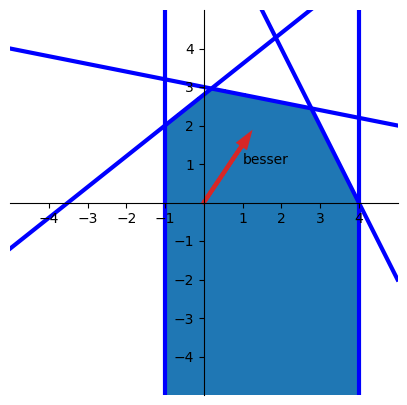

In [3]:
show_poly()

Implementieren wir das lineare Programm! Zunächst müssen wir uns Objekt beschaffen, dass das LP kodiert. Dies geschieht mit <code>mip.Model()</code>. Wir speichern das Objekt in die Variable <code>model</code>.

In [4]:
model=mip.Model()

Als nächstes definieren wir die Variablen $x_1,x_2$, die wir mit <code>x1</code> und <code>x2</code> bezeichnen wollen. Mit <code>z=model.add_var()</code> fügen wir dem LP <code>model</code> eine Variable hinzu und speichern die, zur späteren Verwendung, in <code>z</code>. Standardmäßig darf die Variable alle *nicht-negativen* Werte annehmen. Im obigen LP hingegen ist $-1\leq x_1 \leq 4$ vorgesehen und $x_2$ darf sogar alle Werte in $\mathbb R$ annehmen. Um untere und obere Schranken festzulegen benutzen wir die Parameter <code>lb</code> und <code>ub</code> wie in 

<code>z=model.add_var(lb=-42,ub=100000)</code>

Wie aber legen fest, dass $x_2$ nach unten gar nicht begrenzt ist? Wir verwenden als untere Grenze $-\infty$! In Python können wir uns den Wert $\infty$ durch <code>math.inf</code> beschaffen, $-\infty$ ist dann entsprechend <code>-math.inf</code>.

### Aufgabe: Variablen
Fügen Sie die Variablen <code>x1</code> und <code>x2</code> mit den korrekten Grenzen dem LP <code>model</code> hinzu!

In [5]:
### Fügen Sie hier Ihren Code ein ###

x1=model.add_var(lb=-1,ub=4)
x2=model.add_var(lb=-math.inf)

Als nächstes definieren wir die Zielfunktion. Angenommen wir wollten $42x_1-2x_2$ maximieren. Dann würden wir schreiben:

<code>model.objective=mip.maximize(42\*x1-2\*x2)</code>

Damit haben wir festgelegt, dass wir maximieren wollen und zwar die Funktion $42x_1-2x_2$. Wichtig: Die Zielfunktion muss <code>model</code> auch als Zielfunktion zugewiesen werden. Das geschieht eben durch die Zuweisung <code>model.objective=...</code>. Ebenfalls wichtig: die Zielfunktion muss linear sein. Wenn Sie versuchen als Zielfunktion <code>x1\*x2</code> anzugeben, werden Sie eine Fehlermeldung erhalten.

### Aufgabe: Zielfunktion
Definieren Sie die Zielfunktion für <code>model</code>!

In [6]:
### Fügen Sie hier Ihren Code ein ###

model.objective = mip.maximize(x1+1.5*x2)

Es verbleiben die drei Ungleichungen des linearen Programms. (Die Ungleichung $-1\leq x_1\leq 4$ haben wir bereits durch die untere und obere Grenze an <code>x1</code> eingefangen.) Die Ungleichungen können wir einfach hinschreiben so wie 

<code>27\*x1-15\*x2 \<= 12</code>
    
Eine solche Ungleichung müssen wir allerdings mit <code>model</code> verknüpfen. Das geschieht, indem wir die Ungleichung zu <code>model</code> *addieren*. Dh, wir schreiben:
    
<code>model += 27\*x1-15\*x2 \<= 12</code>
    
(Der Operator <code>+=</code> ist eine Kurzschreibweise für <code>model = model + ...</code>.) Statt <code>\<=</code> können wir auch <code>\>=</code> und <code>==</code> verwenden. Strikte Ungleichungen, also <code>\<</code> oder <code>\></code>, sind jedoch nicht möglich.
    
### Aufgabe: Bedingungen
Fügen Sie Bedingungen zu <code>model</code> hinzu!

In [7]:
### Fügen Sie hier Ihren Code ein ###
model += -4*x1+5*x2 <= 14
model += x1+5*x2 <= 15
model += 2*x1+x2 <= 8

Schließlich müssen wir den solver starten und die Lösung auslesen. Mit <code>model.optimize</code> starten wir den solver. Danach kann die Lösung ausgelesen werden, und zwar durch anhängen von <code>.x</code> an die entsprechende Variable. Dh, für die Variable <code>x1</code> wäre das <code>x1.x</code>. (Ja, das kann manchmal ein wenig verwirrend aussehen. Angenommen zB es gäbe eine Variable <code>x</code>, dann wäre der *Wert* der Variable in <code>x.x</code> gespeichert.)

Wie machen wir nun die Ausgabe? Mit <code>print</code>. Der Funktion <code>print</code> kann man einen Muster-String übergeben, in den dann Werte eingesetzt werden. Das geht so:

<code>print("Hier kommt der erste Wert: {} und dann auch schon der zweite: {}".format(42,27))</code>

Was passiert hier? Überall wo im String geschweifte Klammern <code>{}</code> stehen, setzt <code>format</code> Werte ein, und zwar hier an erster Stelle <code>42</code> und beim zweiten Vorkommen von <code>{}</code> eben die <code>27</code>. Probieren wir das aus:

In [8]:
print("Hier kommt der erste Wert: {} und dann auch schon der zweite: {}".format(42,27))

Hier kommt der erste Wert: 42 und dann auch schon der zweite: 27


Das nutzen wir nun, um die Werte <code>x1.x</code> und <code>x2.x</code> auszugeben. 

### Aufgabe: Optimieren
Starten Sie die Optimierung und geben Sie die optimalen Werte für <code>x1</code> und <code>x2</code> mit <code>print</code> aus!

In [9]:
### Fügen Sie hier Ihren Code ein ###
model.optimize()
print("Optimale Lösung: ")
print("x1={} / x2={}".format(x1.x,x2.x))

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming problem using Primal Simplex

Optimale Lösung: 
x1=2.7777777777777777 / x2=2.4444444444444446


(Der solver ist recht mitteilsam. Wenn Sie das nervt, so können Sie das Geblabbel mit <code>model.verbose=0</code> ausschalten.)

Wir nutzen die obige Visualisierungsmethode, um uns das Optimum auch graphisch anzuzeigen.

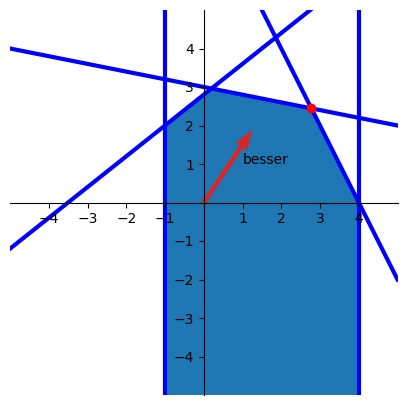

In [10]:
show_poly(solution=(x1.x,x2.x))

Schließlich interessiert uns natürlich auch der Zielfunktionswert am Optimum. Den bekommen wir so:

In [16]:
OPT=model.objective_value
print("Optimaler Zielfunktionswert: {}".format(OPT))

Optimaler Zielfunktionswert: 6.444444444444445
